# HomeWork #6

Завдання 1 <br>
У цьому завданні вам потрібно завантажити ось цей датасет. Тут ви знайдете 2 файли - з двовимірним датасетом та датасетом mnist. Для кожного з них застосуйте алгоритм K-means для кластеризації. Щоб знайти оптимальну кількість кластерів, скористайтесь ліктєвим методом.<br><br>
Завдання 2<br>
Візуалізуйте результат роботи кластеризації. Для випадку з mnist датасетом, вам потрібно ще скористатись алгоримтом PCA щоб зменшити розмірність ваших даних до 2-вимірного варіанту.<br>

In [78]:
from itertools import combinations
import math as m
from pathlib import Path
import pickle
import random
from typing import Union, Optional

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from kneed import KneeLocator
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
import tsfresh  # poetry add tsfresh
%matplotlib inline

## OBTAIN

In [122]:
def read_from_csvfile(file: Path, header: Optional[str]='infer') -> pd.DataFrame:
    """Read content from csv-file and return dataframe from content."""
    df = pd.read_csv(file, header=header)
    
    return df

Читаємо всі датасети з файлів `csv` у папці `data`

In [123]:
dfs = [read_from_csvfile(item, None) for item in Path('data').iterdir() if item.is_file() and item.suffix.lower() in ('.csv',)]

Виділяємо різні набори

In [124]:
data_2d, mnist = dfs[0], dfs[1]

In [125]:
mnist.shape, data_2d.shape

((500, 785), (200, 3))

Так як зазначено що датасет `data_2d` двовимірний, - першу колонку вважатимемо позначенням приналежністю до кластерів.

In [126]:
data_2d.columns = ['y', 'x1', 'x2']

In [127]:
data_2d.head(3)

,y,x1,x2
0,0.0,-0.768716,0.460860
1,0.0,2.687848,2.366961
2,0.0,-0.201379,0.470430


Так як не зазначено нічого що вказує на те що перша колонка позначення приналежності до кластерів, то спершу вважатимемо що всі колонки даних - фічі (параметри), а в другому випадку приймемо, що перша колонка - позначення приналежності до класів (0-9)

In [128]:
mnist.columns = [f'x{el}' for el in range(mnist.shape[1])]

In [129]:
mnist.head(3)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x775,x776,x777,x778,x779,x780,x781,x782,x783,x784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Перевіримо чи є дублікати для першрго стовпця

In [130]:
not mnist['x0'].is_unique, mnist['x0'].min(), mnist['x0'].max()

(True, 0, 9)

Якщо перша колонка - кластери (позначення), то визначимо скільки значень у кожному

In [131]:
clusters = {}
[clusters.update({el:1}) if (clusters.get(el) is None) else clusters.update({el:clusters.get(el)+1}) for el in mnist['x0']]
clusters

{7: 49, 2: 55, 1: 67, 0: 42, 4: 55, 9: 54, 5: 50, 6: 43, 3: 45, 8: 40}

# `data_2d`

## SCRUB & EXPLORE

In [8]:

def draw_2D_many(df: pd.DataFrame, as_x: list, as_y: list, mark: Optional[str], title: str, xlabel: str, ylabel: str, figsize: tuple|None=None) -> None:
    size = figsize or (15, 5)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(df[as_x].values.min(), df[as_x].values.max()+1, int((df[as_x].values.max() - df[as_x].values.min())/df.shape[0]) or 1)
    minor_ticks = np.arange(df[as_x].values.min(), df[as_x].values.max()+1, int((df[as_x].values.max() - df[as_x].values.min())/df.shape[0])/10 or 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks_y = np.arange(df[as_y].values.min(), df[as_y].values.max()+1, int((df[as_y].values.max() - df[as_y].values.min())/df.shape[0]) or 1)
    minor_ticks_y = np.arange(df[as_y].values.min(), df[as_y].values.max()+1, int((df[as_y].values.max() - df[as_y].values.min())/df.shape[0])/10 or 0.1)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)

    classes = set(df[mark]) if mark else ['1']
    for x, y in zip(as_x, as_y):
        [plt.scatter(
                    df[x][df[mark]==m] if mark else df[x], 
                    df[y][df[mark]==m] if mark else df[y], 
                    label=f'{mark}-{m}', 
                    color=random.choice('rgbcmyk'), 
                    marker=random.choice('o+xdvs*.^')
                    ) for m in range(len(classes))]

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    ax.grid(which='both')
    plt.show()

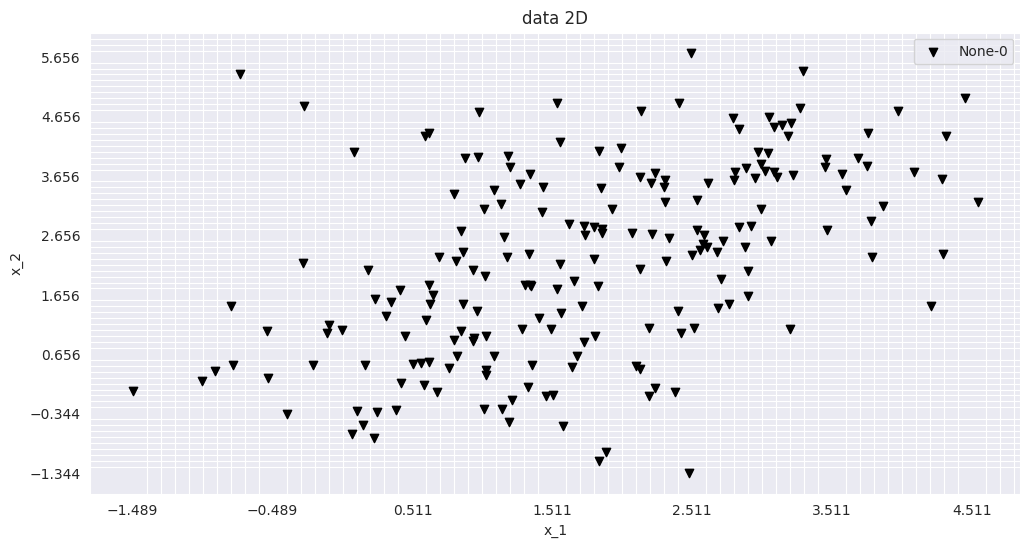

In [51]:
draw_2D_many(df=data_2d, as_x=['c0'], as_y=['c1'], mark=None, title=f'data 2D', xlabel='x_1', ylabel=f'x_2', figsize=(12, 6))

Як бачимо, попередня нормалізація - зайва

## MODEL

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

##### Розрахуємо для розбиття на кластери від 1 до 11

In [10]:
X = data_2d[['x1', 'x2']].to_numpy()
x = [n_clus for n_clus in range(1, 12)]
kmeans = [KMeans(n_clusters=n_clus, random_state=0, n_init='auto').fit(X) for n_clus in x]

In [11]:
y = [km.inertia_ for km in kmeans]

In [12]:
def draw_2D(as_x: list, as_y: list, title: str, xlabel: str, ylabel: str, figsize: tuple|None=None) -> None:
    size = figsize or (15, 5)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x))/len(as_x)) or 1)
    minor_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x))/len(as_x)/10) or 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y))/len(as_y)) or 1)
    minor_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y))/len(as_y)/10) or 0.1)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)


    plt.plot(
             as_x, 
             as_y, 
             label=f'2D', 
             color=random.choice('rgbcmyk'), 
             linestyle=random.choice(['-', '--', '-.', ':', None]),
             marker=random.choice('o+xdvs*.^')
             )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    ax.grid(which='both')
    plt.show()

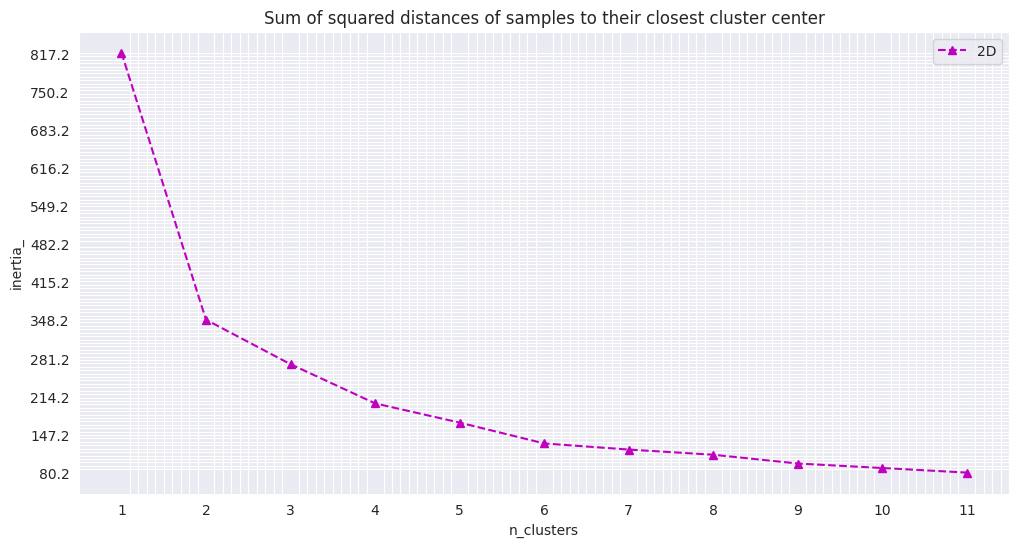

In [50]:
title = 'Sum of squared distances of samples to their closest cluster center'
draw_2D(as_x=x, as_y=y, title=title, xlabel='n_clusters', ylabel=f'inertia_', figsize=(12, 6))

Візуально начебто 2 кластери оптимально, але ...

- https://stackoverflow.com/questions/51762514/find-the-elbow-point-on-an-optimization-curve-with-python
- https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python/13849249#13849249
- https://github.com/arvkevi/kneed

In [14]:
kneedle = KneeLocator(x, y, S=1.0, curve='convex', direction='decreasing')

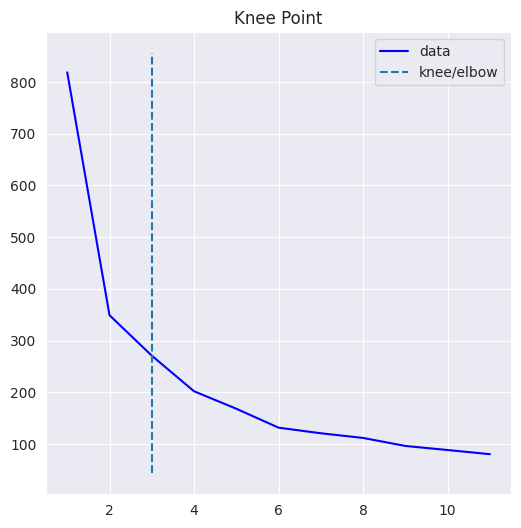

In [52]:
kneedle.plot_knee()

За алгоритмом оптимального значення: кластерів 3, зі значенням (суми) найбільших квадратичних відхилень від центроїдів 270.76

In [16]:
kneedle.knee, kneedle.knee_y

(3, 270.76301490918763)

Відносне зменшення значення найбільших квадратичних відхилень від центроїдів при покрокомому збільшенні кількості кластерів від 1

In [17]:
[(y[el-1]-y[el])/y[el-1] for el in range(len(y)) if el != 0]

[0.5737653082456687,
 0.22409806759241682,
 0.2544183671063387,
 0.16743506444255124,
 0.21781515371328095,
 0.08226000723630648,
 0.07506702535704811,
 0.13883175893527055,
 0.0820044751856831,
 0.09101620656036621]

In [18]:
kmeans[1:3]

[KMeans(n_clusters=2, n_init='auto', random_state=0),
 KMeans(n_clusters=3, n_init='auto', random_state=0)]

##### Якщо взяти з початкових даних перший стовпчик як результат кластеризації (відомий клас)

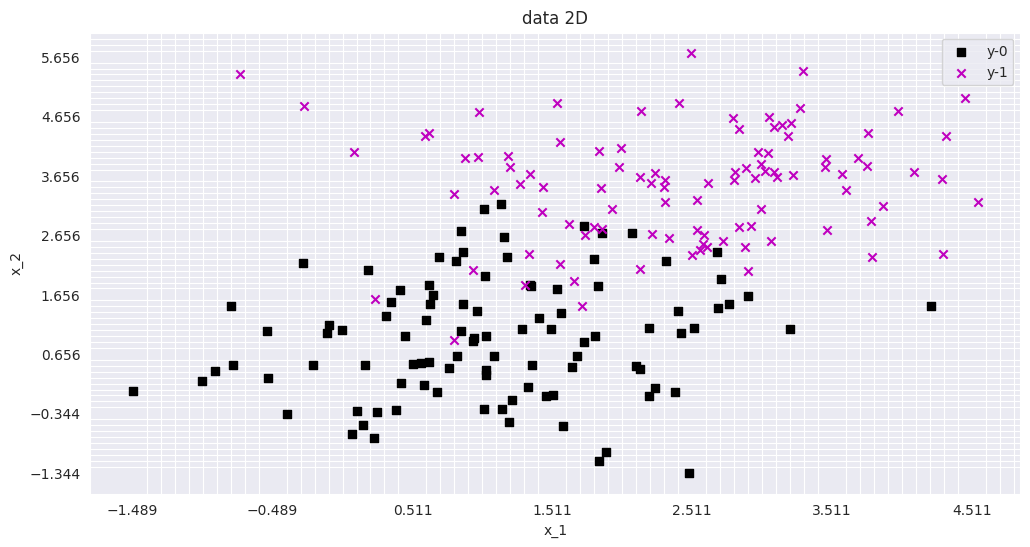

In [55]:
draw_2D_many(df=data_2d, as_x=['x1'], as_y=['x2'], mark='y', title=f'data 2D', xlabel='x_1', ylabel=f'x_2', figsize=(12, 6))

##### Якщо взяти з кластеризацію з розбиттям на 2 класи

In [20]:
kmeans[1].labels_

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0], dtype=int32)

In [21]:
kmeans[1].cluster_centers_

array([[2.46540572, 3.48660748],
       [0.97799508, 0.80217417]])

In [22]:
centroids = pd.DataFrame(kmeans[1].cluster_centers_)
centroids.columns = ['x1-2-x1', 'x2-2-x2']

In [23]:
centroids

,c0-2-x1,c0-2-x2
0,2.465406,3.486607
1,0.977995,0.802174


In [24]:
centroids.iloc[0]['x1-2-x1']

2.465405715770335

In [25]:
start = 0  # kmeans[1].labels_[0]
y2 = {'y2':kmeans[1].labels_}
y2['x1-2-x1'] = [centroids.iloc[0]['x1-2-x1'] if y2['y2'][i] == start else centroids.iloc[1]['x1-2-x1'] for i in range(len(y2['y2']))]
y2['x2-2-x2'] = [centroids.iloc[0]['x2-2-x2'] if y2['y2'][i] == start else centroids.iloc[1]['x2-2-x2'] for i in range(len(y2['y2']))]

In [26]:
y2 = pd.DataFrame(y2)
y2.head()

,y2,c0-2-x1,c0-2-x2
0,1,0.977995,0.802174
1,0,2.465406,3.486607
2,1,0.977995,0.802174
3,1,0.977995,0.802174
4,1,0.977995,0.802174


In [27]:
data_2d_c = pd.concat([data_2d, y2], axis=1)
data_2d_c.head(3)
data_2d_c = data_2d_c.sort_values(by=['y2'])
data_2d_c.head(3)

,y,c0,c1,y2,c0-2-x1,c0-2-x2
99,0.0,1.146001,3.182565,0,2.465406,3.486607
125,1.0,1.094621,3.404889,0,2.465406,3.486607
126,1.0,3.075717,2.548524,0,2.465406,3.486607


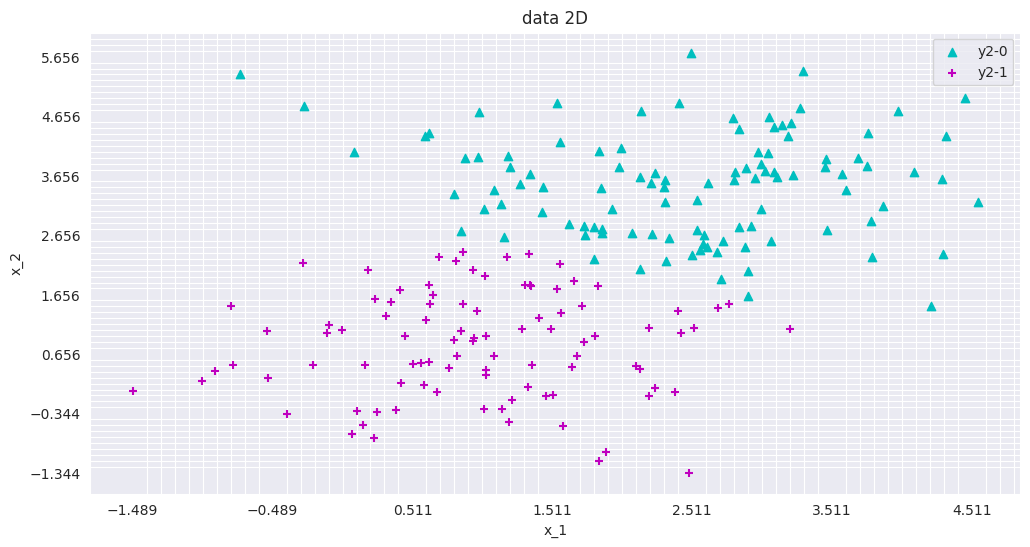

In [56]:
draw_2D_many(df=data_2d_c, as_x=['x1'], as_y=['x2'], mark='y2', title=f'data 2D', xlabel='x_1', ylabel=f'x_2', figsize=(12, 6))

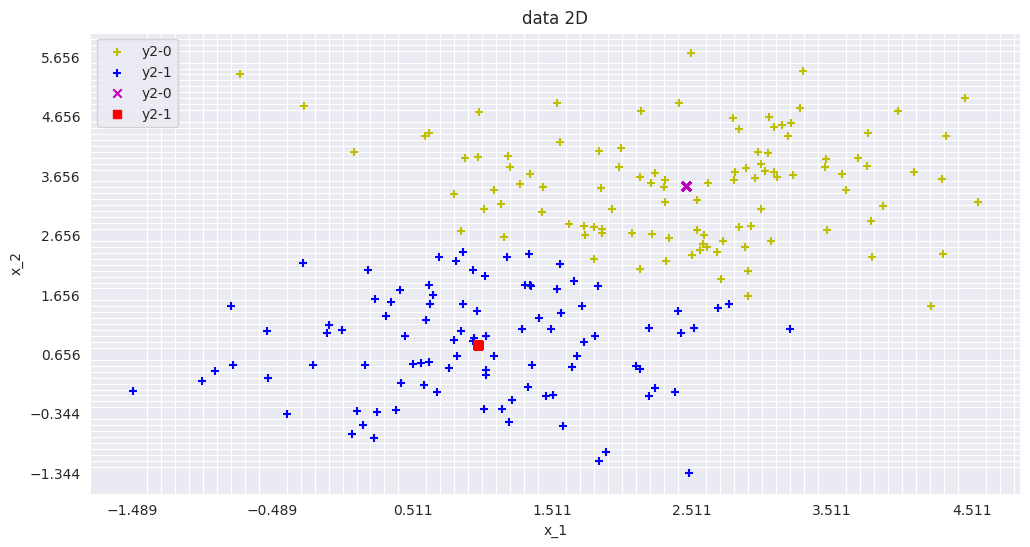

In [60]:
draw_2D_many(df=data_2d_c, as_x=['x1', 'x1-2-x1'], as_y=['x2', 'x2-2-x2'], mark='y2', title=f'data 2D', xlabel='x_1', ylabel=f'x_2', figsize=(12, 6))

##### Якщо взяти з кластеризацію з розбиттям на 3 класи

In [30]:
kmeans[2].labels_

array([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2,
       0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 0, 2, 0,
       2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0], dtype=int32)

In [31]:
kmeans[2].cluster_centers_

array([[2.67513782, 3.99328211],
       [0.74771856, 0.50438896],
       [1.96916569, 2.32414269]])

In [32]:
centroids = pd.DataFrame(kmeans[2].cluster_centers_)
centroids.columns = ['x1-3-x1', 'x2-3-x2']

In [33]:
centroids

,c0-3-x1,c0-3-x2
0,2.675138,3.993282
1,0.747719,0.504389
2,1.969166,2.324143


In [34]:
start = 0  # kmeans[2].labels_[0]
y3 = {'y3':kmeans[2].labels_}
y3['x1-3-x1'] = [
                 centroids.iloc[0]['x1-3-x1'] 
                 if y3['y3'][i] == start 
                 else centroids.iloc[1]['x1-3-x1'] 
                 if y3['y3'][i] == start + 1 
                 else centroids.iloc[2]['x1-3-x1'] 
                 for i in range(len(y3['y3']))
                 ]
y3['x2-3-x2'] = [
                 centroids.iloc[0]['x2-3-x2'] 
                 if y3['y3'][i] == start 
                 else centroids.iloc[1]['x2-3-x2'] 
                 if y3['y3'][i] == start + 1 
                 else centroids.iloc[2]['x2-3-x2']
                 for i in range(len(y3['y3']))]

In [35]:
y3 = pd.DataFrame(y3)
y3.head()

,y3,c0-3-x1,c0-3-x2
0,1,0.747719,0.504389
1,2,1.969166,2.324143
2,1,0.747719,0.504389
3,1,0.747719,0.504389
4,1,0.747719,0.504389


In [36]:
data_2d_c3 = pd.concat([data_2d, y3], axis=1)
data_2d_c3.head(3)
data_2d_c3 = data_2d_c3.sort_values(by=['y3'])
data_2d_c3.head(3)

,y,c0,c1,y3,c0-3-x1,c0-3-x2
199,1.0,3.764228,4.372587,0,2.675138,3.993282
154,1.0,3.003628,3.086627,0,2.675138,3.993282
152,1.0,1.204900,3.796754,0,2.675138,3.993282


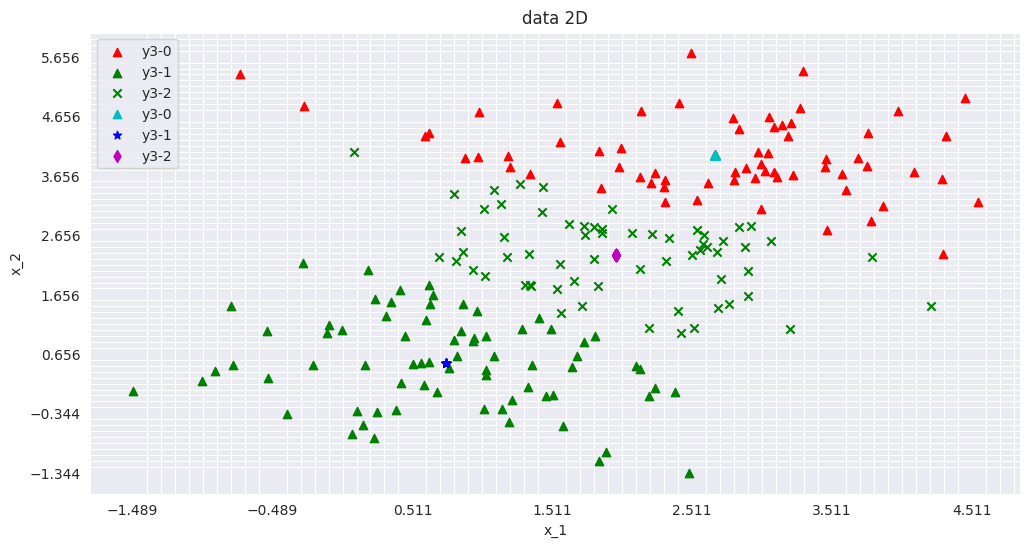

In [63]:
draw_2D_many(df=data_2d_c3, as_x=['x1', 'x1-3-x1'], as_y=['x2', 'x2-3-x2'], mark='y3', title=f'data 2D', xlabel='x_1', ylabel=f'x_2', figsize=(12, 6))

## INTERPRET

In [38]:
kmeans[1].predict([[0, 0], [1.5, 1.7], [2.5, 3.6], [2.6, -0.35], [-0.5, 3], [3.5, 0], [0.5, 5]])

array([1, 1, 0, 1, 1, 1, 0], dtype=int32)

In [39]:
kmeans[2].predict([[0, 0], [1.5, 1.7], [2.5, 3.6], [2.6, -0.35], [-0.5, 3], [3.5, 0], [0.5, 5]])

array([1, 2, 0, 1, 2, 2, 0], dtype=int32)

# `mnist`

## SCRUB & EXPLORE

In [64]:
mnist.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## По аналогії з попереднім датасетом, якщо прийняти колонку 0 як відому приналежність до кластерів (0-9)

 ## Якщо вважати дані з датасету підготовленими

In [105]:
boolean = not mnist['x0'].is_unique      # True (credit to @Carsten)
# boolean = mnist['Student'].duplicated().any() # True
mnist.max()

255

<Axes: >

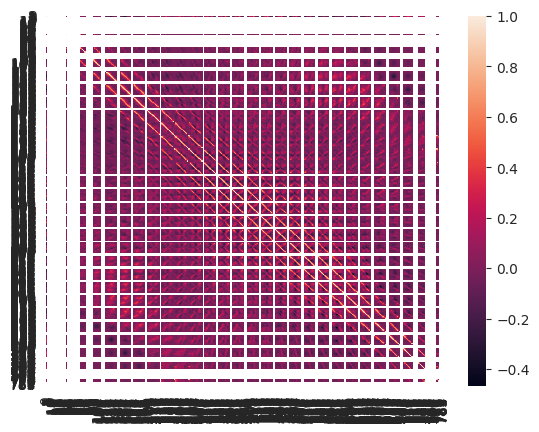

In [65]:
corr = mnist.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# --TEST--- ###############################

In [42]:
from sklearn.cluster import KMeans
import numpy as np

X = np.array([[1, 2], [1, 4], [1, 0],
              [10, 2], [10, 4], [10, 0]])

kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(X)

In [43]:
data_x = pd.DataFrame(X)

In [44]:
data_x.columns = ['c0', 'c1']

Відповідно labels_ - повертає список зі значеннями c(i)c^{(i)}c(i), а cluster_centers_ - це координати центроїдів.

In [45]:
kmeans.labels_

array([1, 1, 1, 0, 0, 0], dtype=int32)

In [46]:
kmeans.predict([[3, 2], [12, 3], [0, 0]])

array([1, 0, 1], dtype=int32)

In [47]:
kmeans.cluster_centers_

array([[10.,  2.],
       [ 1.,  2.]])

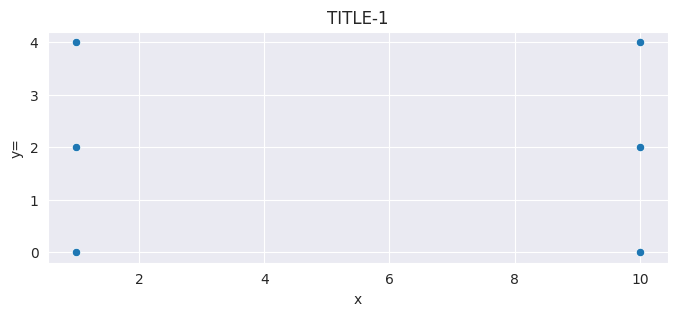

In [48]:
def draw_scatters_sns(df: pd.DataFrame, as_x: list, as_y: list, title: str) -> None:
    plt.figure(figsize=(8, 3))
    sns.set_style('darkgrid')
    [sns.scatterplot(x=x, y=y, data=df) for x, y in zip(as_x, as_y)]
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y=')
    plt.show()

draw_scatters_sns(data_x, as_x=['c0'], as_y=['c1'], title='TITLE-1')

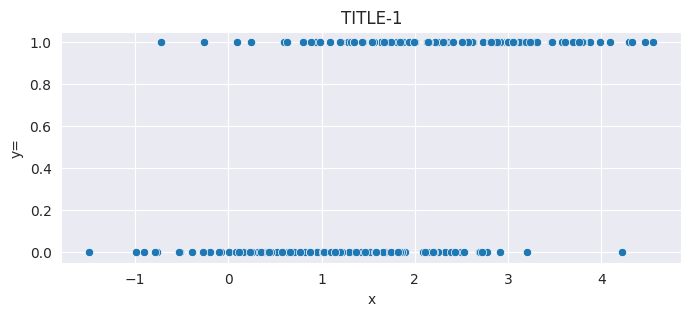

In [49]:
draw_scatters_sns(data_2d, as_x=['c0'], as_y=['y'], title='TITLE-1')